# Машинное обучение и майнинг данных
## 02/02/2017 Введение в sklearn, kNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

<img src='https://s-media-cache-ak0.pinimg.com/originals/ac/29/f4/ac29f41d112cb20512ca6d7ce6b00fa6.jpg'>

[Scikit-learn](http://scikit-learn.org/stable/index.html) (или sklearn) - самая популярная библиотека с алгоритмами машинного обучения и практически всеми необходимыми вспомогательными функциями, которые могут понадобится при подготовке данных, визуализации и оценке качества методов.

На странице модуля можно найти примеры для многих методов с пояснениями.

Рвемся в бой

## Стоимость жилья в Калифорнии

In [8]:
from sklearn.datasets import fetch_california_housing
# import mpl_toolkits.basemap as bm

In [9]:
data = fetch_california_housing()

X = data.data
y = data.target

In [10]:
print data.DESCR

California housing dataset.

The original database is available from StatLib

    http://lib.stat.cmu.edu/

The data contains 20,640 observations on 9 variables.

This dataset contains the average house value as target variable
and the following input variables (features): average income,
housing average age, average rooms, average bedrooms, population,
average occupation, latitude, and longitude in that order.

References
----------

Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
Statistics and Probability Letters, 33 (1997) 291-297.




In [11]:
# Возьмем подвыборку
lllat, lllon = 33, -125
urlat, urlon = 42, -114

idx = (X[:, -1] <= urlon) & (X[:, -1] >= lllon) &\
      (X[:, -2] <= urlat) & (X[:, -2] >= lllat)

X = X[idx]
y = y[idx]

In [12]:
X.shape

(19330, 8)

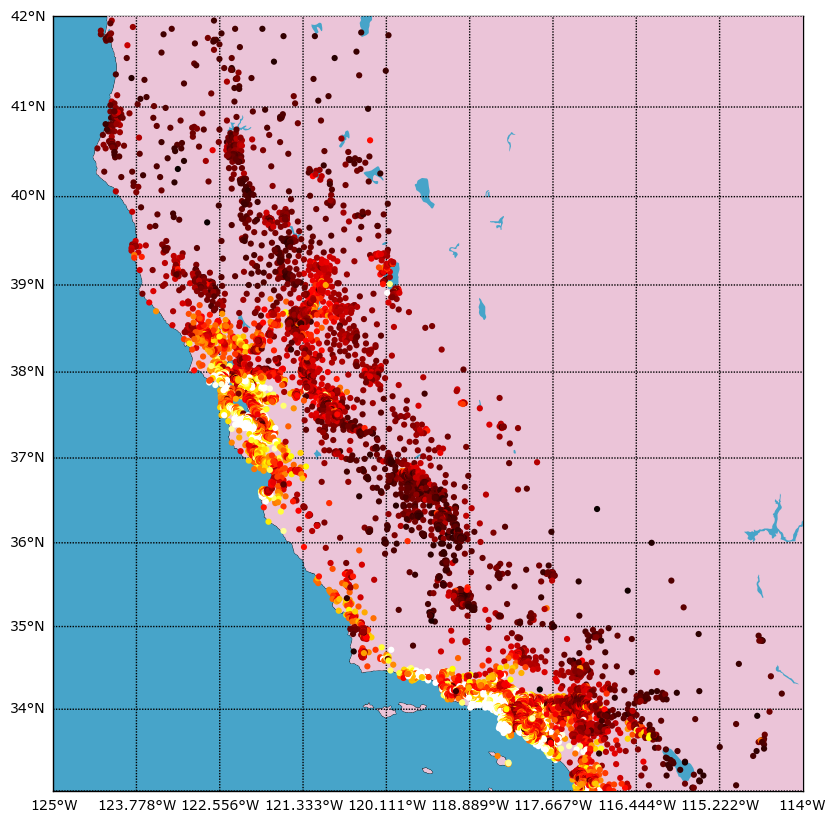

In [6]:
# Нарисуем это дело

plt.figure(figsize=(10, 10))

m = bm.Basemap(
    llcrnrlon=lllon,
    llcrnrlat=lllat,
    urcrnrlon=urlon,
    urcrnrlat=urlat, 
    projection='merc',
    resolution='h'
)

m.drawcoastlines(linewidth=0.5)
m.drawmapboundary(fill_color='#47A4C9', zorder=1)
m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

parallels = np.linspace(lllat, urlat, 10)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.linspace(lllon, urlon, 10)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

m.scatter(X[:, -1], X[:, -2], latlon=True, cmap=plt.cm.hot,
          zorder=3, lw=0, c=y)

### Обучим  KNN

Модели в sklearn - это экземпляры класса в `python`, основными методами которого являются `.fit()`, `.predict()` и иногда `.predict_proba()`

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Если у вас старая версия sklearn
from sklearn.cross_validation import train_test_split 
# from sklearn.model_selection import train_test_split


RND_SEED = 123

In [15]:
# Разбиваем случайным образом на обучение и контроль

X_train, X_test, y_train, y_test = train_test_split(X[:,-2:], y,
                                                    test_size=0.3,
                                                    random_state=RND_SEED)

Список метрик можно найти  [тут](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) 

In [123]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', 
                          metric='euclidean', n_jobs=2)

In [23]:
knn

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=2, n_neighbors=5, p=2,
          weights='uniform')

In [24]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=2, n_neighbors=5, p=2,
          weights='uniform')

### Подбор числа соседей

Зафиксируем все гиперпараметры, кроме числа ближайших соседей.

Переберите значение `k` от 1 до 15, выведите на графике ошибку при каждом `k`.

В будущем, естественно, мы изучем подходы, которые позволяют автоматизировано и эффективно определяеть оптимальные гиперпараметры моделей - например с помощью `GridSearch`, `RandomizedSearch` или [hyperopt](https://github.com/hyperopt/hyperopt).

In [34]:
scores_train = np.empty(14)
scores_test = np.empty(14)

for k in range(1, 15):
    knn = KNeighborsRegressor(n_neighbors=k, weights='uniform', 
                          metric='euclidean', n_jobs=2)
    
    knn.fit(X_train, y_train)
    
    # Предсказание
    y_hat_train = knn.predict(X_train)
    y_hat_test = knn.predict(X_test)
    
    # Oценка качества
    scores_train[k-1] = mean_squared_error(y_train, y_hat_train)
    scores_test[k-1] = mean_squared_error(y_test, y_hat_test)

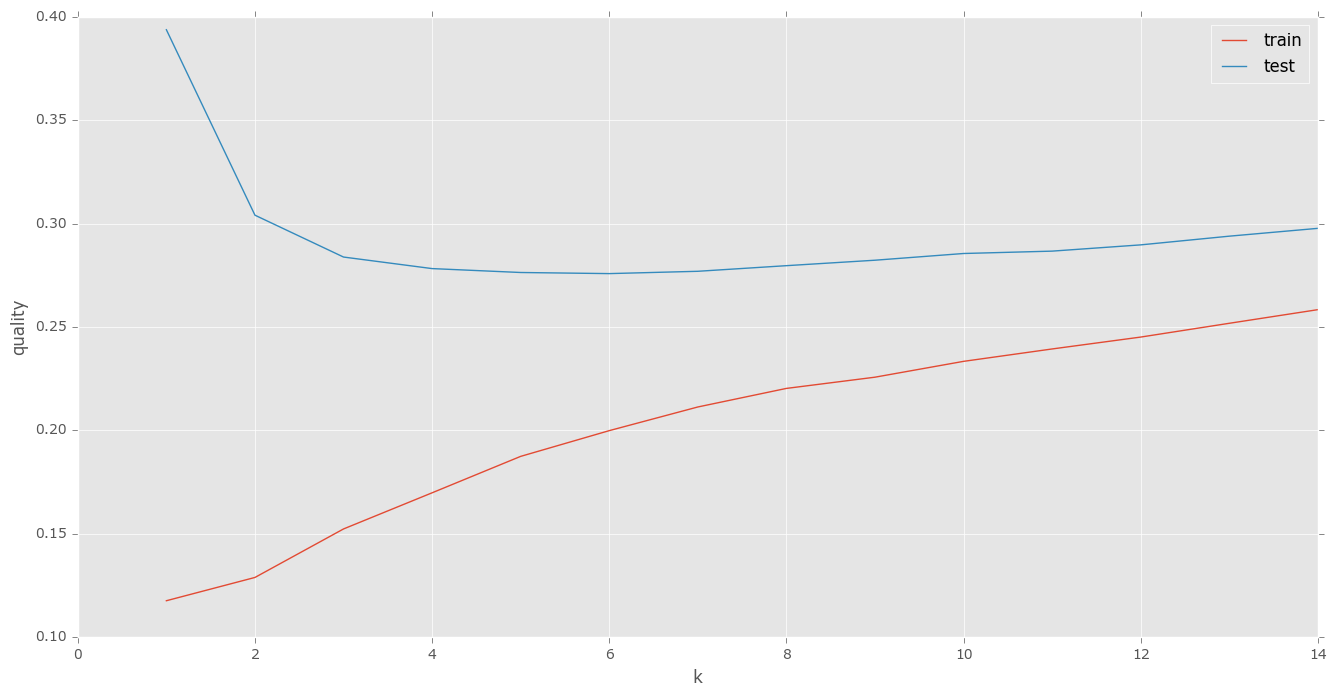

In [38]:
k = range(1,15)
plt.plot(k, scores_train, label='train')
plt.plot(k, scores_test, label='test')
plt.legend()
plt.xlabel('k')
plt.ylabel('quality')

Какая методологическая ошибка здесь допущена?

### Оценка обобщающей способности и выбор гиперпараметров

#### Train + Test

До что мы сделали выше - называется метод отложенной выборки

<img src='https://www.lucypark.kr/courses/2015-dm/images/partition.png' width=700>

Случайным образом разбиваем исходные данные в некоторой пропорции (70/30, 80/20) на обучающую и контрольную выборку.

На одной алгоритм обучается, на другой проверяется его качество.

#### Train + Validation + Test

Иногда встречается трехступенчатая стратегия - теперь добавляется так называемое валидационной множество.

Такая схема подходит если данных достаточно много. <br/> 
Оценка качества надежнее чем в предыдущем случае

<img src='https://dataengr.files.wordpress.com/2016/01/partitions.jpg?w=656'>

#### Cross-validation

В предыдущих случаях не все объекты будут участвовать в обучении.

Можно разбить данные на $k$ равных частей, одну часть использовать для тестирования, а все остальное - для обучения. <br/>
Далее качество по всем фолдам усредняется

<img src='http://blog-test.goldenhelix.com/wp-content/uploads/2015/04/B-fig-1.jpg'>

К сожалению, данный подход можно применить не всегда.

## Данные с оттоком клиентов

Загрузите [данные](https://raw.githubusercontent.com/EricChiang/churn/master/data/churn.csv) об оттоке клиентов через pandas.

In [80]:
df_churn = pd.read_csv('https://raw.githubusercontent.com/EricChiang/churn/master/data/churn.csv')

In [81]:
df_churn.head().T

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account Length,128,107,137,84,75
Area Code,415,415,415,408,415
Phone,382-4657,371-7191,358-1921,375-9999,330-6626
Int'l Plan,no,no,no,yes,yes
VMail Plan,yes,yes,no,no,no
VMail Message,25,26,0,0,0
Day Mins,265.1,161.6,243.4,299.4,166.7
Day Calls,110,123,114,71,113
Day Charge,45.07,27.47,41.38,50.9,28.34


In [82]:
print df_churn.shape

(3333, 21)


Это небольшие данные, но у них есть большие проблемы:

#### Проблема 1: Признаки разных шкал

In [83]:
df_churn.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,3333,51,WV,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Account Length,3333,NaN,NaN,NaN,101.065,39.8221,1,74,101,127,243
Area Code,3333,NaN,NaN,NaN,437.182,42.3713,408,408,415,510,510
Phone,3333,3333,385-6952,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Int'l Plan,3333,2,no,3010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VMail Plan,3333,2,no,2411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VMail Message,3333,NaN,NaN,NaN,8.09901,13.6884,0,0,0,20,51
Day Mins,3333,NaN,NaN,NaN,179.775,54.4674,0,143.7,179.4,216.4,350.8
Day Calls,3333,NaN,NaN,NaN,100.436,20.0691,0,87,101,114,165
Day Charge,3333,NaN,NaN,NaN,30.5623,9.25943,0,24.43,30.5,36.79,59.64


In [84]:
df_churn.loc[:, 'Area Code'].value_counts()

415    1655
510     840
408     838
Name: Area Code, dtype: int64

In [85]:
df_churn.loc[:, 'Area Code'].head()

0    415
1    415
2    415
3    408
4    415
Name: Area Code, dtype: int64

In [86]:
# Как закодировать?
# Вариант №1 
pd.get_dummies(df_churn.loc[:, 'Area Code']).head()

,408,415,510
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0


In [87]:
# Вариант №2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

lab_enc.fit(df_churn.loc[:, 'Area Code'])
area_label = lab_enc.transform(df_churn.loc[:, 'Area Code'])
# Можно сделать в 1 строчка
# area_label = lab_enc.fit_transform(df_churn.loc[:, 'Area Code'])

area_hot = hot_enc.fit_transform(area_label.reshape(-1,1))

In [88]:
# Теперь на новых данных можно использовать эти преобразователи
# С помощью .transform()

#### Проблема 2: Региональные признак
Он может влиять на ответ, но развертывать его в бинарный не имеет смысла.

Можно ли его как-то неявно включить в модель?

In [89]:
df_churn.loc[:, 'State'].nunique()

51

In [90]:
state_pivot = df_churn.pivot_table(index='State', aggfunc='median')

In [91]:
df_churn = df_churn.merge(state_pivot.loc[:, ['Day Calls']], left_on='State', right_index=True)

In [96]:
df_churn.head().T

,0,179,258,287,368
State,KS,KS,KS,KS,KS
Account Length,128,70,92,137,132
Area Code,415,408,408,408,415
Phone,382-4657,411-4582,386-4170,352-8202,369-3214
Int'l Plan,no,no,yes,no,no
VMail Plan,yes,no,no,no,no
VMail Message,25,0,0,0,0
Day Mins,265.1,232.1,62.6,205.9,83.4
Day Calls_x,110,122,111,88,110
Day Charge,45.07,39.46,10.64,35,14.18


#### Проблема 3: Довольно сильный перекос классов

In [93]:
df_churn.loc[:, 'Churn?'].value_counts()

False.    2850
True.      483
Name: Churn?, dtype: int64

#### Задание

1. Подготовьте данные 
    * Удалите ненужные признаки
    * Преобразуйте категориальные и бинарные признаки
    * Отнормируйте признаки
2. Выберите меру качества и метод оценки обобщающей способности
3. Вновь, зафиксируйте все гиперпараметры, кроме количества ближайших соседей, найдите наилучшее значение

In [94]:
## Your code here
df_code = pd.get_dummies(df_churn.loc[:, 'Area Code'])
df_churn = pd.concat((df_churn, df_code), axis=1)

In [98]:
features_2_remove = ['State', 'Area Code', 'Phone']

df_churn = df_churn.drop(features_2_remove, axis=1)

In [99]:
binary_features = ["Int'l Plan", "VMail Plan"]

for fname in binary_features:
    df_churn.loc[:, fname] = df_churn.loc[:, fname].replace({'yes': 1, 'no': 0})

In [106]:
df_churn.loc[:, 'Churn?'] = df_churn.loc[:, 'Churn?'].replace({'True.': 1, 'False.': 0})

In [109]:
# Исходные данные
idx = df_churn.columns == 'Churn?'
X, y = df_churn.loc[:, ~idx].values, df_churn.loc[:, idx].values

In [112]:
# Неправильно делать нормализацию сейчас
# Надо делать отдельно на каждом фолде свою

In [115]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [118]:
model = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])

In [119]:
from sklearn.cross_validation import KFold
# from sklearn.model_selection import KFold

In [120]:
cv = KFold(10, n_folds=3)

In [122]:
for train_idx, test_idx in cv:
    print train_idx
    
    print test_idx
    
    print '-' * 10

[4 5 6 7 8 9]
[0 1 2 3]
----------
[0 1 2 3 7 8 9]
[4 5 6]
----------
[0 1 2 3 4 5 6]
[7 8 9]
----------
